## 1. Loading the dataset

**Task : Regression**

In [1]:
using MLJ
using CSV, DataFrames
using Random, Logging
using Plots
Logging.disable_logging(Logging.Info)

LogLevel(1)

In [2]:
df = CSV.read("data/laptopPrice.csv", DataFrame);
first(df, 5)

Row,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
,String7,String7,String15,String15,String7,String7,String7,String7,String7,String7,String7,String15,String15,String3,String3,Int64,String7,Int64,Int64
1,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
3,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1
4,ASUS,Intel,Core i5,10th,8 GB,DDR4,512 GB,0 GB,Windows,32-bit,2 GB,Casual,No warranty,No,No,69990,3 stars,0,0
5,ASUS,Intel,Celeron Dual,Not Available,4 GB,DDR4,0 GB,512 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,26990,3 stars,0,0


## 2. Assign the correct scientific types

In [3]:
df.ram_gb = parse.(Int, replace.(df.ram_gb, " GB" => ""));
df.ssd = parse.(Int, replace.(df.ssd, " GB" => ""));
df.hdd = parse.(Int, replace.(df.hdd, " GB" => ""));
df.graphic_card_gb = parse.(Int, replace.(df.graphic_card_gb, " GB" => ""));

In [4]:
schema(df)

┌───────────────────┬──────────┬──────────┐
│ names             │ scitypes │ types    │
├───────────────────┼──────────┼──────────┤
│ brand             │ Textual  │ String7  │
│ processor_brand   │ Textual  │ String7  │
│ processor_name    │ Textual  │ String15 │
│ processor_gnrtn   │ Textual  │ String15 │
│ ram_gb            │ Count    │ Int64    │
│ ram_type          │ Textual  │ String7  │
│ ssd               │ Count    │ Int64    │
│ hdd               │ Count    │ Int64    │
│ os                │ Textual  │ String7  │
│ os_bit            │ Textual  │ String7  │
│ graphic_card_gb   │ Count    │ Int64    │
│ weight            │ Textual  │ String15 │
│ warranty          │ Textual  │ String15 │
│ Touchscreen       │ Textual  │ String3  │
│ msoffice          │ Textual  │ String3  │
│ Price             │ Count    │ Int64    │
│ rating            │ Textual  │ String7  │
│ Number of Ratings │ Count    │ Int64    │
│ Number of Reviews │ Count    │ Int64    │
└───────────────────┴──────────┴

In [8]:
df = coerce(df, Count => Continuous, Textual => Multiclass);
schema(df)

┌───────────────────┬────────────────┬────────────────────────────────────┐
│ names             │ scitypes       │ types                              │
├───────────────────┼────────────────┼────────────────────────────────────┤
│ brand             │ Multiclass{8}  │ CategoricalValue{String7, UInt32}  │
│ processor_brand   │ Multiclass{3}  │ CategoricalValue{String7, UInt32}  │
│ processor_name    │ Multiclass{11} │ CategoricalValue{String15, UInt32} │
│ processor_gnrtn   │ Multiclass{8}  │ CategoricalValue{String15, UInt32} │
│ ram_gb            │ Continuous     │ Float64                            │
│ ram_type          │ Multiclass{6}  │ CategoricalValue{String7, UInt32}  │
│ ssd               │ Continuous     │ Float64                            │
│ hdd               │ Continuous     │ Float64                            │
│ os                │ Multiclass{3}  │ CategoricalValue{String7, UInt32}  │
│ os_bit            │ Multiclass{2}  │ CategoricalValue{String7, UInt32}  │
│ graphic_ca

## 3. Data preprocessing

In [6]:
y, X = unpack(df, ==(:Price));

In [9]:
first(y, 5)

5-element Vector{Float64}:
 34649.0
 38999.0
 39999.0
 69990.0
 26990.0

In [10]:
first(X, 5)

Row,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,rating,Number of Ratings,Number of Reviews
,Cat…,Cat…,Cat…,Cat…,Float64,Cat…,Float64,Float64,Cat…,Cat…,Float64,Cat…,Cat…,Cat…,Cat…,Cat…,Float64,Float64
1,ASUS,Intel,Core i3,10th,4.0,DDR4,0.0,1024.0,Windows,64-bit,0.0,Casual,No warranty,No,No,2 stars,3.0,0.0
2,Lenovo,Intel,Core i3,10th,4.0,DDR4,0.0,1024.0,Windows,64-bit,0.0,Casual,No warranty,No,No,3 stars,65.0,5.0
3,Lenovo,Intel,Core i3,10th,4.0,DDR4,0.0,1024.0,Windows,64-bit,0.0,Casual,No warranty,No,No,3 stars,8.0,1.0
4,ASUS,Intel,Core i5,10th,8.0,DDR4,512.0,0.0,Windows,32-bit,2.0,Casual,No warranty,No,No,3 stars,0.0,0.0
5,ASUS,Intel,Celeron Dual,Not Available,4.0,DDR4,0.0,512.0,Windows,64-bit,0.0,Casual,No warranty,No,No,3 stars,0.0,0.0


In [11]:
preproc_pipe = Standardizer() |> OneHotEncoder()
preproc_wrapped = machine(preproc_pipe, X)
X_prepared = MLJ.transform(fit!(preproc_wrapped), X);

## 4. Training and tuning the models

In [12]:
for (model, pkg) in [("RandomForestRegressor", "DecisionTree"),
                     ("LinearRegressor", "MLJLinearModels")]
println(load_path(model, pkg=pkg))
end

MLJDecisionTreeInterface.RandomForestRegressor
MLJLinearModels.LinearRegressor


In [13]:
Forest = @load RandomForestRegressor pkg="DecisionTree"
LM = @load LinearRegressor pkg="MLJLinearModels"

import MLJDecisionTreeInterface ✔
import MLJLinearModels ✔


MLJLinearModels.LinearRegressor

In [14]:
measures = [mae, rms, rsq]
splits = Holdout(fraction_train=0.8, rng=42)
rng_mt = MersenneTwister(42)
for m in [Forest, LM]
    if m==Forest
        eval_report = evaluate(m(rng=rng_mt), X_prepared, y, resampling=splits, measure=measures)
    else
        eval_report = evaluate(m(), X_prepared, y, resampling=splits, measure=measures)
    end
    println(m)
    println.(eval_report.measure, ": ", round.(eval_report.measurement, digits=3))
    println()
end

MLJDecisionTreeInterface.RandomForestRegressor
MeanAbsoluteError(): 10011.39
RootMeanSquaredError(): 16755.6
RSquared(): 0.856

MLJLinearModels.LinearRegressor
MeanAbsoluteError(): 15558.822
RootMeanSquaredError(): 23993.262
RSquared(): 0.675



In [15]:
forest = Forest(rng=rng_mt)

RandomForestRegressor(
  max_depth = -1, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 100, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = MersenneTwister(42, (0, 1254, 0, 0, 0, 1)))

In [16]:
hyperparam_range = [range(forest, :n_trees, lower=10, upper=80),
                    range(forest, :max_depth, lower=2, upper=30)]
self_tuning_forest = TunedModel(
    model=forest,
    resampling=CV(nfolds=4, rng=rng_mt),
    tuning=Grid(resolution=6),
    range=hyperparam_range,
    measure=rms)
mach = machine(self_tuning_forest, X_prepared, y)
fit!(mach, verbosity=1)

Evaluating over 36 metamodels: 100%[=========================] Time: 0:00:15


trained Machine; does not cache data
  model: DeterministicTunedModel(model = RandomForestRegressor(max_depth = -1, …), …)
  args: 
    1:	Source @357 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @876 ⏎ AbstractVector{Continuous}


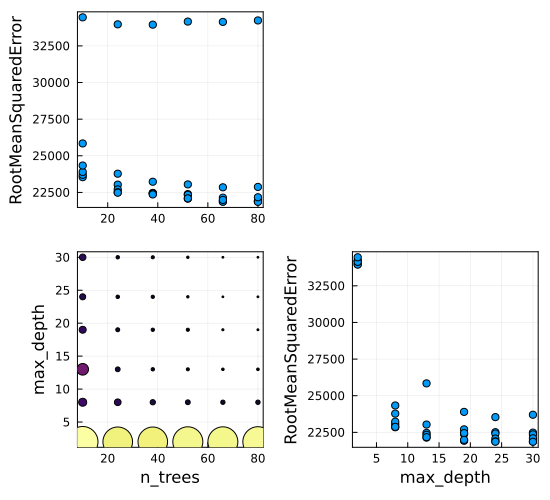

In [17]:
plot(mach)

In [18]:
best_model = fitted_params(mach).best_model

RandomForestRegressor(
  max_depth = 30, 
  min_samples_leaf = 1, 
  min_samples_split = 2, 
  min_purity_increase = 0.0, 
  n_subfeatures = -1, 
  n_trees = 80, 
  sampling_fraction = 0.7, 
  feature_importance = :impurity, 
  rng = MersenneTwister(42, (0, 1254, 0, 0, 0, 6)))

## 5. Evaluate the models

In [19]:
evaluate(best_model, X_prepared, y, resampling=splits, measure=measures)

PerformanceEvaluation object with these fields:
  measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows
Extract:
┌────────────────────────┬───────────┬─────────────┬───────────┐
│ measure                │ operation │ measurement │ per_fold  │
├────────────────────────┼───────────┼─────────────┼───────────┤
│ MeanAbsoluteError()    │ predict   │ 13400.0     │ [13400.0] │
│ RootMeanSquaredError() │ predict   │ 29000.0     │ [29000.0] │
│ RSquared()             │ predict   │ 0.712       │ [0.712]   │
└────────────────────────┴───────────┴─────────────┴───────────┘
